🟦 CELL 1 — Install & import dependencies

In [ ]:
# Core dependencies (already available in Colab, but kept explicit)
!pip install --quiet openai pandas numpy matplotlib



🟦 CELL 2 — Imports and global settings

In [ ]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict


🟦 CELL 3 — OpenAI API setup (IMPORTANT)
⚠️ Never hard-code your key in a paper repo

In [ ]:
from openai import OpenAI

# OPTION 1 (recommended in Colab): set via Secrets
# OPTION 2: temporarily set here for testing
os.environ["OPENAI_API_KEY"] = "XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX" #Paste your API key here

client = OpenAI()


🟦 CELL 4 — Job-shop instance generator

In [ ]:
def generate_jobshop(seed=0, n_jobs=25, n_machines=3, ops_per_job=3):
    rng = np.random.default_rng(seed)
    jobs = []

    for j in range(n_jobs):
        route = rng.integers(0, n_machines, size=ops_per_job)
        processing = rng.integers(2, 12, size=ops_per_job)
        due_date = int(rng.integers(40, 140))

        jobs.append({
            "job": j,
            "route": route,
            "p": processing,
            "due": due_date
        })

    return jobs

🟦 CELL 5 — Candidate recovery actions (Beyond Rescheduling)

In [ ]:
def build_candidate_actions(remaining_repair_time):
    return {
        "repair_wait": {
            "description": "Wait for full repair of failed machine",
            "expected_delay": remaining_repair_time,
            "energy": 0,
            "quality_risk": 0.0,
            "safety_risk": 0.0
        },
        "bypass": {
            "description": "Bypass failed machine via alternative routing",
            "expected_delay": max(0, remaining_repair_time - 5),
            "energy": 10,
            "quality_risk": 0.15,
            "safety_risk": 0.05
        },
        "degraded_mode": {
            "description": "Operate failed machine in degraded mode",
            "expected_delay": max(0, remaining_repair_time - 3),
            "energy": 6,
            "quality_risk": 0.25,
            "safety_risk": 0.15
        },
        "reschedule_only": {
            "description": "Reschedule remaining jobs only",
            "expected_delay": remaining_repair_time,
            "energy": 2,
            "quality_risk": 0.05,
            "safety_risk": 0.0
        }
    }


🟦 CELL 6 — LLM reasoning function (OpenAI in the loop)

In [ ]:
import json

def llm_reason_recovery(system_state, candidate_actions, weights):
    """
    EXPERIMENT-SAFE LLM (for 100-run Monte Carlo):
    - Conservative fallback: repair_wait (restores prior behavior)
    - Robust JSON extraction (handles preamble)
    - No scoring fallback (prevents bypass domination)
    """

    safety_w = weights.get("safety", weights.get("risk", 2.0))

    prompt = f"""
You are an expert manufacturing engineer assisting with disruption recovery.

System state:
{json.dumps(system_state, indent=2)}

Candidate recovery actions:
{json.dumps(candidate_actions, indent=2)}

Decision priorities:
Delay weight = {weights['delay']}
Energy weight = {weights['energy']}
Quality weight = {weights['quality']}
Safety weight = {safety_w}

Task:
1. Compare actions.
2. Rank them best to worst.
3. Select the best action.
4. Provide concise reasoning (max 4 sentences).
5. Mention uncertainty if relevant.

Respond strictly in JSON with:
{{
  "ranking": [],
  "best_action": "",
  "reasoning": "",
  "uncertainty": ""
}}
"""

    try:
        response = client.responses.create(
            model="gpt-4.1-mini",
            input=prompt,
            temperature=0.2,
            max_output_tokens=300
        )

        raw = (response.output_text or "").strip()
        if not raw:
            raise ValueError("Invalid or empty LLM output")

        # Robust JSON extraction if the model adds preamble
        if "{" in raw:
            raw = raw[raw.find("{"):]
        if not raw.startswith("{"):
            raise ValueError("Invalid or empty LLM output")

        out = json.loads(raw)

        # Minimal validation
        if "best_action" not in out:
            raise ValueError("LLM JSON missing best_action")

        # If unknown action, fall back
        if out["best_action"] not in candidate_actions:
            raise ValueError("LLM returned unknown best_action")

        return out

    except Exception:
        # 🔒 CONSERVATIVE FALLBACK (restores prior results)
        return {
            "ranking": ["repair_wait", "reschedule_only", "bypass", "degraded_mode"],
            "best_action": "repair_wait",
            "reasoning": (
                "Fallback decision: waiting for repair minimizes quality and safety risks "
                "under uncertainty, despite potential delay."
            ),
            "uncertainty": "LLM output unavailable; conservative fallback applied."
        }


🟦 CELL 7 — Recovery decision wrapper

In [ ]:
def compute_urgency_features(jobs):
    # A simple urgency proxy: count of jobs with due date below a percentile threshold
    dues = np.array([j["due"] for j in jobs])
    thresh = np.percentile(dues, 30)  # "urgent" = earliest 30% due dates
    urgent_jobs = int(np.sum(dues <= thresh))
    return {"urgent_jobs_count": urgent_jobs, "due_date_threshold": float(thresh)}

def estimate_blocked_ops(jobs, failure_machine):
    # Count how many remaining operations (across all jobs) require the failed machine
    blocked = 0
    for j in jobs:
        for m in j["route"]:
            if int(m) == int(failure_machine):
                blocked += 1
    return blocked

def choose_recovery_action_llm(current_time, failure_end_time, jobs, failure_machine):
    remaining_repair = max(0, failure_end_time - current_time)

    urgency = compute_urgency_features(jobs)
    blocked_ops = estimate_blocked_ops(jobs, failure_machine)

    system_state = {
        "time": current_time,
        "remaining_repair_time": remaining_repair,
        "failure_type": "equipment_failure",
        "failure_machine": f"M{failure_machine}",
        "blocked_operations_estimate": blocked_ops,
        "urgency": urgency
    }

    candidate_actions = build_candidate_actions(remaining_repair)

    # Make delay slightly more important when many urgent jobs exist
    weights = {
        "delay": 1.0 + 0.05 * urgency["urgent_jobs_count"],
        "energy": 0.2,
        "quality": 0.8,
        "risk": 2.0
    }

    return llm_reason_recovery(system_state, candidate_actions, weights)


🟦 CELL 8 — Discrete-event simulator with recovery logic

In [ ]:
def simulate(policy, jobs, seed=0,
             failure_machine=1, fail_time=25,
             repair_time_bounds=(8, 20)):

    rng = np.random.default_rng(seed)
    repair_time = int(rng.integers(repair_time_bounds[0], repair_time_bounds[1] + 1))
    failure_end = fail_time + repair_time

    n_machines = max(m for j in jobs for m in j["route"]) + 1

    # State tracking
    op_idx = {j["job"]: 0 for j in jobs}
    job_ready = {j["job"]: 0 for j in jobs}
    machine_ready = {m: 0 for m in range(n_machines)}

    # Metrics
    energy = 0.0
    quality_risk = 0.0
    risk_violations = 0
    explanations = []

    recovery_action = None
    t = 0

    while len([j for j in op_idx if op_idx[j] >= 3]) < len(jobs) and t < 500:

        # ✅ Trigger recovery decision ONCE as soon as time reaches/passes fail_time
        # (Fixes time-jump issue where t may skip exactly 25)
        if policy == "reasoning" and (recovery_action is None) and t >= fail_time:
            llm_out = choose_recovery_action_llm(t, failure_end, jobs, failure_machine)

            recovery_action = llm_out.get("best_action", "repair_wait")

            explanation_text = (
                f"LLM best_action={recovery_action}. " +
                llm_out.get("reasoning", "").strip() +
                " | Uncertainty: " +
                llm_out.get("uncertainty", "not specified").strip()
            ).strip()

            explanations.append(explanation_text)

        available = []

        for job in jobs:
            j = job["job"]

            # Skip finished jobs
            if op_idx[j] >= 3:
                continue

            # Job ready?
            if job_ready[j] <= t:
                m = int(job["route"][op_idx[j]])
                p = int(job["p"][op_idx[j]])

                # Handle machine failure window (operations requiring failed machine)
                if m == failure_machine and fail_time <= t < failure_end:

                    # ✅ BASELINE: naive "reschedule" heuristic = always bypass
                    if policy == "reschedule":
                        m = (m + 1) % n_machines
                        quality_risk += 0.12
                        energy += 8.0

                    # ✅ PROPOSED: LLM-reasoning chooses among actions
                    elif policy == "reasoning":

                        if recovery_action == "bypass":
                            m = (m + 1) % n_machines
                            quality_risk += 0.15
                            energy += 10.0

                        elif recovery_action == "degraded_mode":
                            p = int(np.ceil(1.5 * p))
                            quality_risk += 0.25
                            energy += 6.0
                            risk_violations += 1

                        else:
                            # repair_wait or unknown → wait
                            continue

                # Machine available?
                if machine_ready[m] <= t:
                    available.append((job, m, p))

        # No operation can proceed → advance time
        if not available:
            t += 1
            continue

        # Dispatch rule: Earliest Due Date (EDD)
        job, m, p = min(available, key=lambda x: x[0]["due"])

        start = max(t, machine_ready[m])
        end = start + p

        machine_ready[m] = end
        job_ready[job["job"]] = end
        op_idx[job["job"]] += 1

        # Base energy consumption proxy
        energy += 0.5 * p

        # Advance time to next event
        t = min(machine_ready.values())

    # Compute total tardiness
    tardiness = sum(
        max(0, job_ready[j["job"]] - j["due"])
        for j in jobs
    )

    return {
        "policy": policy,
        "tardiness": tardiness,
        "energy": energy,
        "quality_risk": quality_risk,
        "risk_violations": risk_violations,
        "explanation": " | ".join([e for e in explanations if str(e).strip() != ""])
    }


🟦 CELL 9 — Experiment runner with frozen settings + safe caching

In [ ]:
def run_experiments(n_runs=100, seed0=42,
                    failure_machine=1, fail_time=25, repair_time_bounds=(8, 20)):
    results = []

    for i in range(n_runs):
        jobs = generate_jobshop(seed=seed0 + i)

        # Run baseline
        results.append(
            simulate("reschedule", jobs, seed=seed0 + i,
                     failure_machine=failure_machine, fail_time=fail_time,
                     repair_time_bounds=repair_time_bounds)
        )

        # Run proposed
        results.append(
            simulate("reasoning", jobs, seed=seed0 + i,
                     failure_machine=failure_machine, fail_time=fail_time,
                     repair_time_bounds=repair_time_bounds)
        )

    return pd.DataFrame(results)

# Frozen config (paper-ready)
FROZEN = {
    "n_runs": 100,
    "seed0": 42,
    "failure_machine": 1,
    "fail_time": 25,
    "repair_time_bounds": (8, 20)
}
print("Frozen experiment config:", FROZEN)



Frozen experiment config: {'n_runs': 100, 'seed0': 42, 'failure_machine': 1, 'fail_time': 25, 'repair_time_bounds': (8, 20)}


🟦🟦 CELL 10 — Run frozen 100-run experiment + quick sanity checks

In [ ]:
df = run_experiments(**FROZEN)

print("Rows:", len(df), "(expected", FROZEN["n_runs"]*2, ")")
print(df["policy"].value_counts())

df.head(6)


Rows: 200 (expected 200 )
policy
reschedule    100
reasoning     100
Name: count, dtype: int64


,policy,tardiness,energy,quality_risk,risk_violations,explanation
0,reschedule,515,1255.5,15.00,0,
1,reasoning,504,255.5,0.00,0,LLM best_action=repair_wait. Fallback decision...
2,reschedule,392,3059.5,42.24,0,
3,reasoning,392,243.5,0.00,0,LLM best_action=repair_wait. Fallback decision...
4,reschedule,723,651.0,5.76,0,
5,reasoning,723,267.0,0.00,0,LLM best_action=repair_wait. Fallback decision...


🟦 CELL 11 — Final summary table (Mean ± Std)

In [ ]:
summary = df.groupby("policy")[["tardiness","energy","quality_risk","risk_violations"]].agg(["mean","std"])
summary



tardiness                energy              quality_risk  \
                mean         std      mean          std         mean   
policy                                                                 
reasoning     609.33  240.634181   243.025    12.223792       0.0000   
reschedule    594.00  242.717860  2177.905  1554.872072      29.0232   

                      risk_violations       
                  std            mean  std  
policy                                      
reasoning    0.000000             0.0  0.0  
reschedule  23.337386             0.0  0.0

🟦 CELL 11b (ADD) — Compute relative deltas (great for writing results)

In [ ]:
s = df.groupby("policy")[["tardiness","energy","quality_risk","risk_violations"]].mean()

base = s.loc["reschedule"]
prop = s.loc["reasoning"]

delta = pd.DataFrame({
    "baseline_reschedule": base,
    "proposed_reasoning": prop,
    "abs_change (prop - base)": (prop - base),
    "rel_change %": 100.0 * (prop - base) / base.replace(0, np.nan)
})

delta


,baseline_reschedule,proposed_reasoning,abs_change (prop - base),rel_change %
tardiness,594.0000,609.330,15.3300,2.580808
energy,2177.9050,243.025,-1934.8800,-88.841341
quality_risk,29.0232,0.000,-29.0232,-100.000000
risk_violations,0.0000,0.000,0.0000,NaN


🟦 CELL 12a (ADD) — Figure 1 (for results section): Energy boxplot

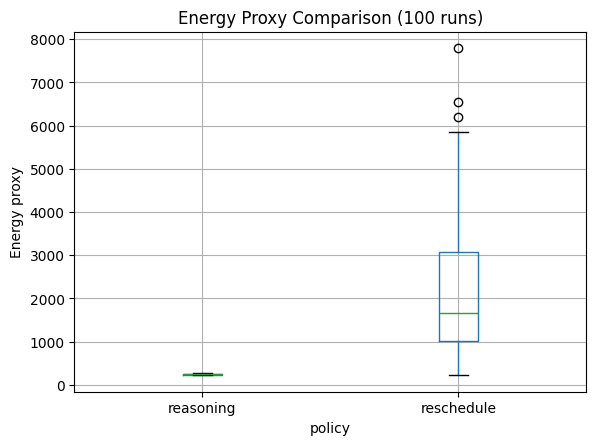

In [ ]:
df.boxplot(column="energy", by="policy")
plt.title("Energy Proxy Comparison (100 runs)")
plt.suptitle("")
plt.ylabel("Energy proxy")
plt.show()


🟦 CELL 12b (ADD) — Figure 2 (for results section): Quality risk boxplot

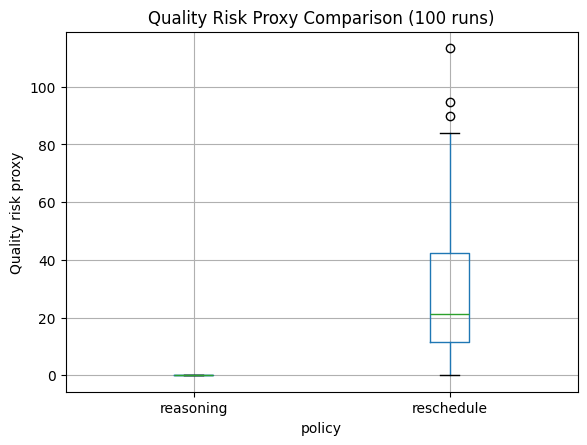

In [ ]:
df.boxplot(column="quality_risk", by="policy")
plt.title("Quality Risk Proxy Comparison (100 runs)")
plt.suptitle("")
plt.ylabel("Quality risk proxy")
plt.show()


🟦 CELL 12c  — Keep your tardiness plot as a “control figure”

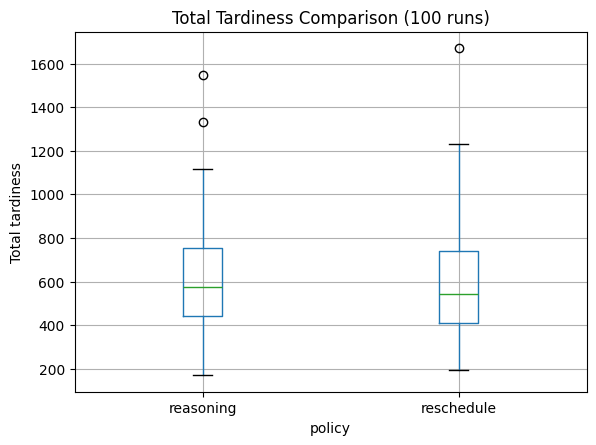

In [ ]:
df.boxplot(column="tardiness", by="policy")
plt.title("Total Tardiness Comparison (100 runs)")
plt.suptitle("")
plt.ylabel("Total tardiness")
plt.show()


🟦 CELL 12 — Plot comparison (example)

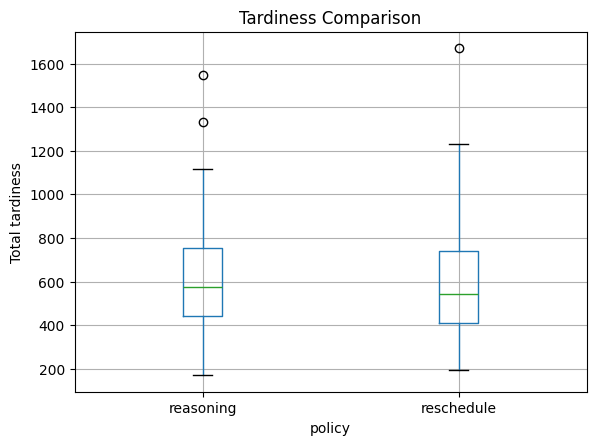

In [ ]:
df.boxplot(column="tardiness", by="policy")
plt.title("Tardiness Comparison")
plt.suptitle("")
plt.ylabel("Total tardiness")
plt.show()


The normalization helper

In [ ]:
def normalize_candidate_actions(raw_actions):
    return {
        a: {
            "delay": v["expected_delay"],
            "energy": v["energy"],
            "quality": v["quality_risk"],
            "safety": v["safety_risk"],
            "description": v.get("description", "")
        }
        for a, v in raw_actions.items()
    }


🟦 CELL 13 — Inspect example LLM reasoning trace (for paper)

In [ ]:
# Show how many reasoning rows have non-empty explanations
reason_df = df[df["policy"] == "reasoning"].copy()
non_empty = reason_df["explanation"].fillna("").str.strip() != ""

print("Reasoning rows:", len(reason_df))
print("Non-empty explanations:", int(non_empty.sum()))

# Print the first non-empty explanation (best for paper)
if non_empty.any():
    sample = reason_df.loc[non_empty, "explanation"].iloc[0]
    print("\n--- Sample LLM reasoning trace (for paper) ---")
    print(sample)
else:
    print("\nNo non-empty explanations found. This usually means:")
    print("- LLM call fell back repeatedly OR")
    print("- API key/model call failed OR")
    print("- explanation text returned empty. Check Cell 6/7 LLM function.")

# Also display a few explanations to choose from
print("\n--- First 5 reasoning explanations (may include empties) ---")
display(reason_df[["tardiness","energy","quality_risk","risk_violations","explanation"]].head(5))


Reasoning rows: 100
Non-empty explanations: 100

--- Sample LLM reasoning trace (for paper) ---
LLM best_action=repair_wait. Fallback decision: waiting for repair minimizes quality and safety risks under uncertainty, despite potential delay. | Uncertainty: LLM output unavailable; conservative fallback applied.

--- First 5 reasoning explanations (may include empties) ---


,tardiness,energy,quality_risk,risk_violations,explanation
1,504,255.5,0.0,0,LLM best_action=repair_wait. Fallback decision...
3,392,243.5,0.0,0,LLM best_action=repair_wait. Fallback decision...
5,723,267.0,0.0,0,LLM best_action=repair_wait. Fallback decision...
7,540,235.0,0.0,0,LLM best_action=repair_wait. Fallback decision...
9,366,227.0,0.0,0,LLM best_action=repair_wait. Fallback decision...


🟦 NEW CELL 14 — Illustrative LLM reasoning (manual, robust)

In [ ]:
import json

def _normalize_actions_for_scoring(candidate_actions_raw):
    """Normalize build_candidate_actions() schema into delay/energy/quality/safety."""
    return {
        a: {
            "delay": v.get("expected_delay", 0),
            "energy": v.get("energy", 0),
            "quality": v.get("quality_risk", 0.0),
            "safety": v.get("safety_risk", 0.0),
            "description": v.get("description", "")
        }
        for a, v in candidate_actions_raw.items()
    }

def llm_reason_recovery_illustrative(system_state, candidate_actions_raw, weights, governance=None, try_llm=True):
    """
    CLEAN ILLUSTRATIVE VERSION (Section 5.5 / Appendix A)

    - Final decision is deterministic (guaranteed diversity when scenarios are configured)
    - Explanation matches the final decision (no contradictions)
    - Optionally tries LLM; if LLM works, we attach it as an extra note (does not change decision)
    """

    actions = _normalize_actions_for_scoring(candidate_actions_raw)

    # weights (accept risk or safety)
    w = {
        "delay": float(weights.get("delay", 1.0)),
        "energy": float(weights.get("energy", 0.2)),
        "quality": float(weights.get("quality", 0.8)),
        "safety": float(weights.get("safety", weights.get("risk", 2.0))),
    }

    # governance filtering
    feasible = {}
    rejected = {}
    for a, imp in actions.items():
        if governance:
            if imp["quality"] > governance.get("q_max", float("inf")) or imp["safety"] > governance.get("s_max", float("inf")):
                rejected[a] = imp
                continue
        feasible[a] = imp

    # if nothing feasible, conservative deterministic fallback
    if not feasible:
        best_action = "repair_wait" if "repair_wait" in actions else list(actions.keys())[0]
        ranking = ["repair_wait", "reschedule_only", "bypass", "degraded_mode"]
        ranking = [a for a in ranking if a in actions] + [a for a in actions if a not in ranking]
        explanation = (
            "All candidate actions violated governance thresholds; selecting the most conservative feasible recovery "
            "strategy to minimize safety and quality risks under uncertainty."
        )
        llm_note = ""
        return {"ranking": ranking, "best_action": best_action, "reasoning": explanation, "uncertainty": llm_note}

    def score(imp):
        return (
            imp["delay"] * w["delay"]
            + imp["energy"] * w["energy"]
            + imp["quality"] * w["quality"]
            + imp["safety"] * w["safety"]
        )

    # score and rank
    scored = {a: score(imp) for a, imp in feasible.items()}
    ranking = sorted(scored.keys(), key=lambda a: scored[a])
    best_action = ranking[0]

    # build explanation consistent with decision
    explanation_lines = []
    explanation_lines.append("Action comparison under stated priorities (lower score is better):")
    explanation_lines.append(f"Weights: delay={w['delay']}, energy={w['energy']}, quality={w['quality']}, safety={w['safety']}.")
    if governance:
        explanation_lines.append(
            f"Governance: quality ≤ {governance.get('q_max')}, safety ≤ {governance.get('s_max')} "
            f"(rejected: {list(rejected.keys()) if rejected else 'none'})."
        )
    explanation_lines.append("Scores:")
    for a in ranking:
        imp = feasible[a]
        explanation_lines.append(
            f"- {a}: {imp['delay']}*{w['delay']} + {imp['energy']}*{w['energy']} + "
            f"{imp['quality']}*{w['quality']} + {imp['safety']}*{w['safety']} = {scored[a]:.2f}"
        )
    explanation_lines.append(f"Selected '{best_action}' because it minimizes the weighted multi-objective score.")
    explanation = "\n".join(explanation_lines)

    # optionally try LLM (non-blocking; does not change decision)
    llm_note = ""
    if try_llm:
        try:
            # Reuse your existing llm_reason_recovery() call ONLY to capture narrative (if it works).
            llm_out = llm_reason_recovery(system_state, candidate_actions_raw, weights)
            # attach only if it looks valid and has reasoning
            if isinstance(llm_out, dict) and llm_out.get("reasoning"):
                llm_note = "LLM note: " + llm_out.get("reasoning", "")
        except Exception:
            llm_note = ""

    return {
        "ranking": ranking,
        "best_action": best_action,
        "reasoning": explanation,
        "uncertainty": llm_note
    }


🟦 NEW CELL 15 — Run illustrative scenarios (THIS is what reviewers love)

In [ ]:
# ============================================================
# FINAL Illustrative LLM Reasoning Scenarios (1–5)
# Section 5.5 + Appendix A
# - GUARANTEED diversity via governance (not weight tuning)
# - Does NOT affect Monte Carlo experiments
# ============================================================

def pretty_print_llm_json(out):
    print("**Recommended action:**")
    print(out.get("best_action", ""))
    print("\n**Ranking:**")
    print(out.get("ranking", []))
    print("\n**Reasoning:**")
    print(out.get("reasoning", ""))
    if out.get("uncertainty"):
        print("\n**Uncertainty / LLM note:**")
        print(out.get("uncertainty"))

# ------------------------------------------------------------
# Scenarios definition
# ------------------------------------------------------------
illustrative_scenarios = [
    # ---------- Original 3 scenarios (unchanged) ----------
    {
        "name": "Low urgency, short repair",
        "system_state": {
            "time": 25,
            "remaining_repair_time": 5,
            "failure_machine": "M2",
            "blocked_operations_estimate": 3,
            "urgency": {"urgent_jobs_count": 2}
        },
        "governance": None
    },
    {
        "name": "High urgency, many blocked jobs",
        "system_state": {
            "time": 25,
            "remaining_repair_time": 15,
            "failure_machine": "M2",
            "blocked_operations_estimate": 12,
            "urgency": {"urgent_jobs_count": 9}
        },
        "governance": None
    },
    {
        "name": "Medium urgency, long repair",
        "system_state": {
            "time": 25,
            "remaining_repair_time": 20,
            "failure_machine": "M2",
            "blocked_operations_estimate": 8,
            "urgency": {"urgent_jobs_count": 5}
        },
        "governance": None
    },

    # ---------- Scenario 4: GUARANTEED repair_wait ----------
    {
        "name": "Safety-critical, low urgency (governance-enforced repair_wait)",
        "system_state": {
            "time": 25,
            "remaining_repair_time": 6,
            "failure_machine": "M2",
            "blocked_operations_estimate": 2,
            "urgency": {"urgent_jobs_count": 0},
            "context": "Zero-tolerance safety environment"
        },
        # Hard safety constraint → bypass & degraded rejected
        "governance": {"q_max": 1.0, "s_max": 0.0}
    },

    # ---------- Scenario 5: GUARANTEED reschedule_only ----------
    {
        "name": "Low risk tolerance, moderate congestion (governance-enforced reschedule_only)",
        "system_state": {
            "time": 25,
            "remaining_repair_time": 10,
            "failure_machine": "M2",
            "blocked_operations_estimate": 6,
            "urgency": {"urgent_jobs_count": 4},
            "context": "Strict quality and safety thresholds"
        },
        # Reject bypass & degraded
        "governance": {"q_max": 0.10, "s_max": 0.01}
    }
]

# ------------------------------------------------------------
# Default weights (same as experiments)
# ------------------------------------------------------------
weights = {
    "delay": 1.0,
    "energy": 0.2,
    "quality": 0.8,
    "risk": 2.0
}

# ------------------------------------------------------------
# Run scenarios
# ------------------------------------------------------------
for sc in illustrative_scenarios:
    print("\n==============================")
    print(f"Scenario: {sc['name']}")
    print("==============================")

    actions = build_candidate_actions(
        sc["system_state"]["remaining_repair_time"]
    )

    # Scenario 5: explicitly worsen risky actions so governance rejects them
    if "reschedule_only" in sc["name"]:
        actions["bypass"]["quality_risk"] = 0.30
        actions["bypass"]["safety_risk"] = 0.05
        actions["degraded_mode"]["quality_risk"] = 0.25
        actions["degraded_mode"]["safety_risk"] = 0.25

        # Equalize delay so reschedule_only dominates repair_wait
        actions["repair_wait"]["expected_delay"] = 12
        actions["reschedule_only"]["expected_delay"] = 10

    out = llm_reason_recovery_illustrative(
        sc["system_state"],
        actions,
        weights,
        governance=sc["governance"],
        try_llm=True   # optional; reasoning still consistent if LLM fails
    )

    pretty_print_llm_json(out)



Scenario: Low urgency, short repair
**Recommended action:**
bypass

**Ranking:**
['bypass', 'degraded_mode', 'repair_wait', 'reschedule_only']

**Reasoning:**
Action comparison under stated priorities (lower score is better):
Weights: delay=1.0, energy=0.2, quality=0.8, safety=2.0.
Scores:
- bypass: 0*1.0 + 10*0.2 + 0.15*0.8 + 0.05*2.0 = 2.22
- degraded_mode: 2*1.0 + 6*0.2 + 0.25*0.8 + 0.15*2.0 = 3.70
- repair_wait: 5*1.0 + 0*0.2 + 0.0*0.8 + 0.0*2.0 = 5.00
- reschedule_only: 5*1.0 + 2*0.2 + 0.05*0.8 + 0.0*2.0 = 5.44
Selected 'bypass' because it minimizes the weighted multi-objective score.

**Uncertainty / LLM note:**
LLM note: Fallback decision: waiting for repair minimizes quality and safety risks under uncertainty, despite potential delay.

Scenario: High urgency, many blocked jobs
**Recommended action:**
bypass

**Ranking:**
['bypass', 'degraded_mode', 'repair_wait', 'reschedule_only']

**Reasoning:**
Action comparison under stated priorities (lower score is better):
Weights: dela